## Implementation and optimization of the mean-timer technique in drift tube detectors

Alessandro Marcomini (2024286), Andrea Scanu (2022460), Samuele Piccinelli (2027650), Cristina Venturini (2022461) - `GROUP 6`

## Outline <br>

The project is organized as following:

1. INTRODUCTION
2. PREPARING THE DATA
3. FINDING EVENTS
4. VISUALISING THE EVENTS
5. CONCLUSION
6. APPENDIX: CODE OPTIMIZATION

---

Importing useful libraries: 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colors, patches
from matplotlib.lines import Line2D
from os import listdir
from os.path import isfile, join
from numba import vectorize, int64, int32
import time
from tqdm.notebook import tqdm

## 1. Introduction

The project consists in analyzing data coming from a series of 4 particle detectors, with the goal of reconstructing the trajectory of the particle passing through them. <br>
Each detector is composed of 4 layers of 16 cells, with a particular numeration, as shown in the figure. Each cell measures the time of the electronic signal released at the passage of a charged particle: the particle ionizes and the produced electrons drift at constant velocity towards the anodic wire at the center of the cell. <br>
The final goal is to precisely assess the exact position where a particle has traversed a given cell; combining the information of consecutive cells it is then possible to deduce the trajectory of the particle.
Under the assumption of constant drift velocity within the entire cell, the time taken by the ionization to reach the anodic wire (drift time) is proportional to the distance:

$$
x = v_d (t_{abs} - t_0)
$$

where $v_d$ is the constant drift velocity, $t$ is the *absolute* time recorded by the electronics (i.e. the data we have) and $t_0$ is a time pedestal - which we need to determine - corresponding to the time where the particle crosses the detector (the drift time is $t-t_0$). <br>
To determine $t_0$ we exploit the fact that the layers are staggered by exactly half a cell: as said in the [NOTE2007_034.pdf](https://core.ac.uk/download/pdf/44189221.pdf) this allows to use a set of equations (different cases based on which layer was the hit recorded on) to spot the passage of a particle. One of these equations is as follows: <br>

$$
T_{Max} = \frac{t'_1+t'_3}{2}+t'_2
$$ 

where $t'_1$, $t'_2$, $t'_3$ are the drift times of those three cells and $T_{Max}$ is the maximum drift time, a known constant quantity: $T_{Max} = \frac{L}{2 v_d} = 390$ ns ($L=42$ mm is the lenght of the cell). <br>
From the equation above, knowing $t_1$, $t_2$, $t_3$, in the case of cells like in the picture, one can extract the value of the time pedestal ($t_0$), thus the drift times in each cell, and thus the position of the hit within the cell (although with the left-right ambiguity). <br>
In the case of different patterns of cells, there's a list of equations regarding each specific case always in `NOTE2007_034.pdf`. <br>
<br>
As for the data structure, it was a csv file with 6 columns: `HEAD` (useless for our analysis), `FPGA` (0 or 1), `TDC_CHANNEL` (1-128 and 137, 138, 139), `ORBIT_CNT`, `BX_COUNTER`, `TDC_MEAS` (these three containing the time information). <br>
`FPGA` and `TDC_CHANNEL` map the four detectors as: <br>
<br>
Detector 1 $\rightarrow$ `FPGA` = 0, `TDC_CHANNEL` (1-64) <br>
Detector 2 $\rightarrow$ `FPGA` = 0, `TDC_CHANNEL` (65-128) <br>
Detector 3 $\rightarrow$ `FPGA` = 1, `TDC_CHANNEL` (1-64) <br>
Detector 4 $\rightarrow$ `FPGA` = 1, `TDC_CHANNEL` (65-128) <br>
<br>

Since it is stated that the physics run is mainly composed of background events and that events with detector noise are to be discarded, we decided to concentrate on the calibration runs, where most of the hits can be associated to the actual track of a particle.

## 2. Preparing the data

The data are encoded in a CSV file and the analysis was performed on a calibration run in which most of the hits can be associated to a particle's track.

This is code to import the data, in particular to concatenate the multiple files present in the `Run000260` folder and create a Pandas dataframe. Due to the long compile time a restricted version of the dataset was considered.<br>
The first 10 hits in the raw data are presented below.

In [ ]:
'''
path = "Group6"
files = [join(path, f) for f in listdir(path) if isfile(join(path, f))]
# concatenate the files and load the data
data = pd.concat([pd.read_csv(file) for file in files], axis = 0)
data.reset_index(inplace=True, drop=True)
display(data.head(10))
'''

In [2]:
file_name = "Run000260/data_000000.txt"
data = pd.DataFrame(pd.read_csv(file_name), columns=["HEAD","FPGA","TDC_CHANNEL","ORBIT_CNT","BX_COUNTER","TDC_MEAS"])

We subsequently drop the `HEAD` column, since it's useless, and we also drop the rows containing the trigger information, since the technique later used to identify the events doesn't use it. <br>

As for our understanding of the assignement, the trigger information was to be neglected, since the data were acquired using an acquisition system which read the detectors' sensors at $40$ MHz (every $25$ ns) without the need for an external trigger. <br>
Also, we dropped all the rows containing a `TDC_CHANNEL` above 128.

In [3]:
data = data.drop(columns = ['HEAD'])
indexNames = data[(data['TDC_CHANNEL'] >= 137) & (data['TDC_CHANNEL'] <= 139)].index
data.drop(indexNames, inplace=True)
data.drop(data[(data['TDC_CHANNEL'] > 128)].index, inplace=True)
display(data.head())

,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS
0,1,116,1897414884,1533.0,24.0
1,1,71,1897414887,1650.0,21.0
2,1,67,1897414914,980.0,8.0
3,1,70,1897414922,1287.0,8.0
4,0,57,1897414922,2162.0,22.0


### 2.1 Adding new columns

Here we compute the *absolute* time for each row of the dataframe, converting the information given in `TDC_MEAS` and `BX_COUNTER` in ns, and storing it in a new column, called `Absolute`. We also sort the values in the dataframe by the absolute time value. <br>
We don't consider the information given by the `ORBIT_CNT` since to identify events we are going to restrict ourselves to finding one event in one orbit, as will be explained later.

In [4]:
absolute_time =  data["BX_COUNTER"]*25 + data["TDC_MEAS"]*25/30
data["Absolute"] = pd.Series(absolute_time, index = data.index)
data = data.sort_values(by="Absolute")
display(data.head())

,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS,Absolute
364419,1,92,1918734190,0.0,0.0,0.000000
775017,1,13,1919726264,0.0,0.0,0.000000
1184557,0,118,1920689489,0.0,0.0,0.000000
34168,0,53,1897559326,0.0,1.0,0.833333
1153675,1,8,1920563621,0.0,1.0,0.833333


We then define three functions, `chamber()`, `layer()`, `cell()`, that add a column each to the original dataframe with information regarding the chamber (detector), layer and cell the hit was recorded on.

Those functions were initially built with a if statement which made the code cumbersome. We managed to enhance the performance thanks to a `@vectorize` decorator.

In [5]:
@vectorize([int64(int64,int64)], nopython=True)
def chamber(fpga, tdc):
    return (tdc // 64 + 1) + 2*fpga

@vectorize([int64(int64)], nopython=True)
def layer(tdc):
    index = {0:1, 2:2, 3:3, 1:4}
    key = tdc % 64 % 4
    return index[key]

@vectorize([int64(int64)], nopython=True)
def cell(tdc):
    return tdc % 64

In [6]:
data['Chamber'] = chamber(data['FPGA'].values, data['TDC_CHANNEL'].values)
data['Layer'] = layer(data['TDC_CHANNEL'].values)
data['Cell'] = cell(data['TDC_CHANNEL'].values)
display(data.head())

,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS,Absolute,Chamber,Layer,Cell
364419,1,92,1918734190,0.0,0.0,0.000000,4,1,28
775017,1,13,1919726264,0.0,0.0,0.000000,3,4,13
1184557,0,118,1920689489,0.0,0.0,0.000000,2,2,54
34168,0,53,1897559326,0.0,1.0,0.833333,1,4,53
1153675,1,8,1920563621,0.0,1.0,0.833333,3,1,8


Here we drop some other rows of the dataframe that are not relevant for the analysis: if a specific `ORBIT_CNT` value presents itself less than 3 times it is impossible that that specific orbit contains an event, since we consider only orbits with 3 or 4 hits to call an event.

In [7]:
def filter_by_freq(df, column, min_freq):
    freq = df[column].value_counts()
    frequent_values = freq[freq >= min_freq].index
    return df[df[column].isin(frequent_values)]


data = filter_by_freq(data,"ORBIT_CNT",3)

We add an empty column `Event`; we divide the data in 4 different dataframes containing the hits of a single detector, which will be later needed for the analysis.

In [8]:
data["Event"] = 0
Tmax = 390.         # some useful constants
L2 = 21.

detector1 = data[(data['Chamber'] == 1)]
detector2 = data[(data['Chamber'] == 2)]
detector3 = data[(data['Chamber'] == 3)]
detector4 = data[(data['Chamber'] == 4)]

detectors = [detector1, detector2, detector3, detector4]

We then plot two histograms, one for each `FPGA`, with the number of hits for each `TDC_CHANNEL`:

<Figure size 432x288 with 0 Axes>

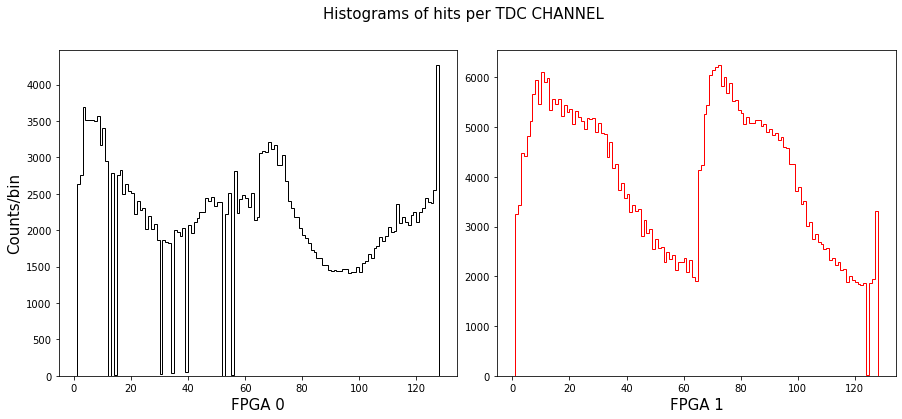

In [9]:
detector12 = data[(data['FPGA'] == 0)]
detector34 = data[(data['FPGA'] == 1)]

plt.clf()
fig, axes = plt.subplots(nrows=1, ncols=2, tight_layout=False, figsize=(15, 6), sharey=False)
fig.subplots_adjust(wspace=0.1)
ax0, ax1 = axes.flatten()
data0, bins, __ = ax0.hist(detector12["TDC_CHANNEL"].values, bins=np.arange(1,129,1), range=(detector12["TDC_CHANNEL"].min(), detector12["TDC_CHANNEL"].max()), histtype='step', color="black")
ax0.set_xlabel(r"FPGA 0", size=15)
ax0.set_ylabel(r"Counts/bin", size=15)
data1, bins, __ = ax1.hist(detector34["TDC_CHANNEL"].values, bins=np.arange(1,129,1), range=(detector34["TDC_CHANNEL"].min(), detector34["TDC_CHANNEL"].max()), histtype='step', color="red")
ax1.set_xlabel(r"FPGA 1", size=15)
fig.suptitle(r"Histograms of hits per TDC CHANNEL", size=15)
plt.show()

From the graphs above one can see that some channels have significantly less counts than others: this can be due to a difference in performance between the cells.

***

## 3. Finding events

Once we have prepared the data, we move on to actually solving the problem and finding the events. To do so, we make some assumptions as to what happens in a detector and about the data we have. <br> 
First of all, since the rate of passage of particles through the detector is rather limited, i.e. the chance to get two particle within the same orbit is extremely small, we assume that we can find no more than one event for each orbit. <br>

As for what we consider an event, we take into account only layers and orbits with 3 or 4 hits that are roughly aligned. By that we mean that the track of the particle crosses a semi-column of cells, i.e. the interested wires are at the same position for each couple of staggered cells. Given the small thickness of the layers and the muon velocity (which is much higher than the drift velocity of the electrons), the time pedestal $t_0$ of an event is assumed to be equal for all cells.<br>
In the figure we highlighted an example of the cells interested in the search of an event.<br>

An event is identified by the number of the layer of the cells the hit was recorded on: we consider events of all types, e.g. 1234, 123, 124, 134, 234.

<img src = "event.png" style = "width:571.2px; height:274.4px"/>

### 3.1 Identifying events (L/R ambiguity unresolved)

In this part we identify the events by iterating on each detector and each orbit: the goal of the algorithm is to assign a common tag to rows belonging to the same event. In this way it will be easier to access all information a specific event. 

For each orbit we look for a couple of staggered cells: the program first identifies a cell $n$ in the first layer in which a hit occurred and checks if in the $n-1$ cell, which belongs to the third layer, there's an event happening at a distance in time less than $T_{max}$, a necessary condition to register an event. <br>
If this condition is verified it looks for the third and fourth component of the event in the 4 cells which we have marked as compatible, according to the request of having an almost vertical track. <br>
To avoid the degenerate cases of 4 hits with only two staggered cells (the ones from first and third layer) and the remaining ones not correctly aligned, a condition based on the sum of the cells labels has been implemented. <br>
Analogously the process is executed starting from cells of the second layer: this allows us to also find events with a couple of staggered cells in layers 2 and 4 (e.g. an event of type 124, not found with the previous code).

In [10]:
def find_events(detec, n_ev):
    ORBs = detec['ORBIT_CNT'].sort_values().drop_duplicates()
    df_events = pd.DataFrame(index = [], columns = data.columns)              # create an empy dataframe to save the events

    for cnt in tqdm(ORBs):
        df = detec[detec.ORBIT_CNT == cnt]
        idx_l1 = df.index[df["Layer"] == 1]
        idx_l2 = df.index[df["Layer"] == 2]

        for i in idx_l1:                                                      # iterate on first layer cells
            cell1 = df.at[i,'Cell']
            for j in df.index[df["Cell"] == cell1 - 1]:
                if np.abs(df.at[i,'Absolute'] - df.at[j,'Absolute']) < Tmax:  # look for compatible signal in staggered cells
                    n_ev += 1
                    df.at[i, "Event"] = n_ev                                  # assign event tag
                    df.at[j, "Event"] = n_ev
                    Tmean = (df.at[i,'Absolute'] + df.at[j,'Absolute'])/2
                    compatible_k = df.index[df["Cell"] == cell1 - 2].append(df.index[df["Cell"] == cell1 - 6]).append(df.index[df["Cell"] == cell1 - 3]).append(df.index[df["Cell"] == cell1 - 7])
                    for k in compatible_k:
                        if (np.abs(df.at[k,'Absolute'] - Tmean) < Tmax) : df.at[k, "Event"] = n_ev

        for i in idx_l2:                                                      # iterate on second layer cells
            if df.at[i, 'Event'] == 0:
                cell2 = df.at[i,'Cell']
                for j in df.index[df["Cell"] == cell2 - 1]:
                    if np.abs(df.at[i,'Absolute'] - df.at[j,'Absolute']) < Tmax and df.at[j,'Event'] == 0:
                        n_ev += 1
                        df.at[i, "Event"] = n_ev
                        df.at[j, "Event"] = n_ev
                        Tmean = (df.at[i,'Absolute'] + df.at[j,'Absolute'])/2
                        compatible_k = df.index[df["Cell"] == cell2 + 1].append(df.index[df["Cell"] == cell2 + 5]).append(df.index[df["Cell"] == cell2 + 2]).append(df.index[df["Cell"] == cell2 + 6])
                        for k in compatible_k:
                            if (np.abs(df.at[k,'Absolute'] - Tmean) < Tmax) : df.at[k, "Event"] = n_ev

        sizes = df.sort_values(by="Event").groupby("Event").size()
        cellnum = df.sort_values(by="Event").groupby("Event")["Cell"].sum()
        # filter only events with 3 or 4 hits and aligned events
        check = [((s == 3) or (s == 4 and c % 8 != 6)) for s, c in zip(sizes, cellnum)]
        check[0] = False
        events = df["Event"].sort_values().drop_duplicates()[check] 
        for e in events: df_events = df_events.append(df[df["Event"] == e].sort_values(by="Layer"))
    return df_events, n_ev

In [11]:
n_ev = 0
DF_EVENTS = pd.DataFrame(index = [], columns = data.columns)

for detec in detectors:                                                        # iterate on every detector
    df_events, n_ev = find_events(detec, n_ev)
    DF_EVENTS = DF_EVENTS.append(df_events)

In [12]:
print("total number of events: ", DF_EVENTS["Event"].nunique())
display(DF_EVENTS.head(30))

total number of events:  33900


,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS,Absolute,Chamber,Layer,Cell,Event
761,0,20,1897418583,2539.0,17.0,63489.166667,1,1,20,2
757,0,19,1897418583,2528.0,16.0,63213.333333,1,3,19,2
758,0,17,1897418583,2537.0,9.0,63432.500000,1,4,17,2
1307,0,48,1897421321,195.0,6.0,4880.000000,1,1,48,9
1306,0,47,1897421321,190.0,7.0,4755.833333,1,3,47,9
1310,0,45,1897421321,202.0,0.0,5050.000000,1,4,45,9
1971,0,48,1897425108,1167.0,6.0,29180.000000,1,1,48,13
1968,0,46,1897425108,1166.0,19.0,29165.833333,1,2,46,13
1977,0,45,1897425108,1166.0,18.0,29165.000000,1,4,45,13
2059,0,20,1897425590,120.0,19.0,3015.833333,1,1,20,14


### 3.2 Finding the time pedestal $t_0$ and resolving the L/R ambiguity

After filtering the dataframe in order to recognize all suitable events, we proceed to determine the time pedestal $t_0$ of each event, given the absolute time of each signal. Following the mean-timer technique and adapting formulas to the case of different layers, we found the following relations for the events when 3 cells are hit (parentheses are referred to interested layers):

$$
t_0 \ (1,2,3) = \frac{t_1 + t_3 + 2t_2}{4} - \frac{T_{max}}{2}
$$

$$
t_0 \ (1,2,4) = \frac{3t_2 - t_4 + 2t_1}{4} - \frac{T_{max}}{2}
$$

$$
t_0 \ (1,3,4) = \frac{3t_3 - t_1 + 2t_4}{4} - \frac{T_{max}}{2}
$$

The case of layers 2,3,4 is equal in form to the one of layers 1,2,3, with proper substitution.<br>
The case in which all the four layers are hit presents multiple possible relations which provide various $t_0$ estimations. We think that the assumption made *a priori* that ionization occurs at the same time in all the cells (i.e., the cells involved are hit altogether) better holds for consecutive cells, rather than for ones more distant in space. As a result, we calculate the time pedestal of each subset of consecutive cells (the one belonging to layers 1,2,3 and 2,3,4, respectively) and let $t_0$ be the mean of the  returned values:

$$
t_0 \ (1,2,3,4) = \frac{t_0 \ (1,2,3) + t_0 \ (2,3,4)}{2} = 
 \frac{t_1 + 3t_2 + 3t_3 + t_4}{8} - \frac{T_{max}}{2}
$$

Given $t_0$, it is straightforward to find the drift time of electrons in each cell as $t_{drift} = t_{abs} - t_0$ and assuming a constant drift velocity the spatial coordinate of the pacticles' track can be found by proportion:

$$
x(t_{drift}) = \frac{t_{drift}}{T_{max}} \cdot \frac{L_{max}}{2} = t_{drift} \cdot 0.054 \ \left( \frac{mm}{ns} \right)
$$

To resolve the Right-Left ambiguity and determine the sign of the angle of incidence $\alpha$ we take into account all possible cases and select the correct one given the interested cells and the relative position in them.

In [13]:
def Pedestal_123(t1, t2, t3, c1, c2, c3, Tmax = Tmax):    # sum = 6
    t0 = (t1 + t3 + 2*t2)/4 - Tmax/2
    if c2 == c1 - 2: a, l = np.sign(t3-t1), ['R','L','R']
    else: a, l = np.sign(t1-t3), ['L','R','L']
    return t0, a, l

def Pedestal_124(t1, t2, t4, c1, c2, c4, Tmax = Tmax):    # sum = 7
    t0 = (3*t2 - t4 + 2*t1)/4 - Tmax/2
    if c1 == c2 + 2: a, l = np.sign(t2-t4), ['R','L','L']
    else: a, l = np.sign(t4-t2), ['L','R','R']
    return t0, a, l

def Pedestal_134(t1, t3, t4, c1, c3, c4, Tmax = Tmax):    # sum = 8
    t0 = (3*t3 - t1 + 2*t4)/4 - Tmax/2
    if c3 == c4 + 2: a, l = np.sign(t3-t1), ['R','R','L']
    else: a, l = np.sign(t1-t3), ['L','L','R']
    return t0, a, l

def Pedestal_234(t2, t3, t4, c2, c3, c4, Tmax = Tmax):    # sum = 9
    t0 = (t2 + t4 + 2*t3)/4 - Tmax/2
    if c3 == c2 + 5: a, l = np.sign(t4-t2), ['R','L','R']
    else: a, l = np.sign(t2-t4), ['L','R','L']
    return t0, a, l

def Pedestal_1234(t1, t2, t3, t4, c1, c2, c3, c4, Tmax = Tmax):    
    t01, a01, l01 = Pedestal_123(t1,t2,t3,c1,c2,c3)
    t02, a02, l02 = Pedestal_234(t2,t3,t4,c2,c3,c4)
    l = np.array([l01[0], l01[1], l01[2], l02[2]])
    return np.mean([t01, t02]), np.mean([a01, a02]), l

Ped = { 6: Pedestal_123,                                 # assign proper function for each layer pattern
        7: Pedestal_124,
        8: Pedestal_134,
        9: Pedestal_234}

def Find_pedestal(df):
    if len(df.index) == 3:
        Sum = df["Layer"].sum()
        tx, ty, tz = df["Absolute"]
        c1, c2, c3 = df["Cell"]
        if Sum in np.arange(6,10,1): t0, a, l = Ped[Sum](tx, ty, tz, c1, c2, c3)
        else: t0, a, l = 1e5, 1, ["e" , "e", "e"]
        return t0, a, l
    elif len(df.index) == 4:
        tx, ty, tz, tw = df["Absolute"]
        c1, c2, c3, c4 = df["Cell"]
        t0, a, l = Pedestal_1234(tx, ty, tz, tw, c1, c2, c3, c4)
        if (df["Layer"].sum() == 10): return t0, a, l
        else: return 1e5, 1, ["e" for i in range(4)]
    #else: return 1e5, 1, ["e" for i in range(len(df.index))]

DF_off = pd.DataFrame(index = [], columns = DF_EVENTS.columns)
alphas = {1.: '+', -1.: '-', 0.: '?', 0.5: '?', -0.5:'?'}             # labels to identify positive/negative incidence angle
EVs = DF_EVENTS["Event"].sort_values().drop_duplicates()              # (unknown sign for vertical events) 

for e in tqdm(EVs):                                                   # iterate over events
    df = DF_EVENTS[DF_EVENTS["Event"] == e].sort_values(by="Layer")
    t0, a, l = Find_pedestal(df)
    df["T_drift"] = df["Absolute"] - t0                               # adds column with drift time
    df["X(mm)"] = df["T_drift"]/Tmax*21                               # adds column with position
    df["LR"] = np.array(l)                                            # adds column with L/R tag
    df["Alpha"] = alphas[a]                                           # adds column with alpha angle
    # save events with acceptable drift times
    if ((df["T_drift"] > 0.) & (df["T_drift"] < Tmax)).all(): DF_off = DF_off.append(df)

In [14]:
print("total number of events: ", DF_off["Event"].nunique())
display(DF_off.head(30))

total number of events:  28490


,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS,Absolute,Chamber,Layer,Cell,Event,T_drift,X(mm),LR,Alpha
1307,0,48,1897421321,195.0,6.0,4880.000000,1,1,48,9,203.125000,10.937500,R,-
1306,0,47,1897421321,190.0,7.0,4755.833333,1,3,47,9,78.958333,4.251603,R,-
1310,0,45,1897421321,202.0,0.0,5050.000000,1,4,45,9,373.125000,20.091346,L,-
1971,0,48,1897425108,1167.0,6.0,29180.000000,1,1,48,13,201.875000,10.870192,R,+
1968,0,46,1897425108,1166.0,19.0,29165.833333,1,2,46,13,187.708333,10.107372,L,+
1977,0,45,1897425108,1166.0,18.0,29165.000000,1,4,45,13,186.875000,10.062500,L,+
2059,0,20,1897425590,120.0,19.0,3015.833333,1,1,20,14,367.291667,19.777244,R,-
2056,0,18,1897425590,108.0,13.0,2710.833333,1,2,18,14,62.291667,3.354167,L,-
2055,0,17,1897425590,111.0,18.0,2790.000000,1,4,17,14,141.458333,7.616987,L,-
2524,0,58,1897428038,7.0,2.0,176.666667,1,2,58,21,23.958333,1.290064,L,-


<Figure size 432x288 with 0 Axes>

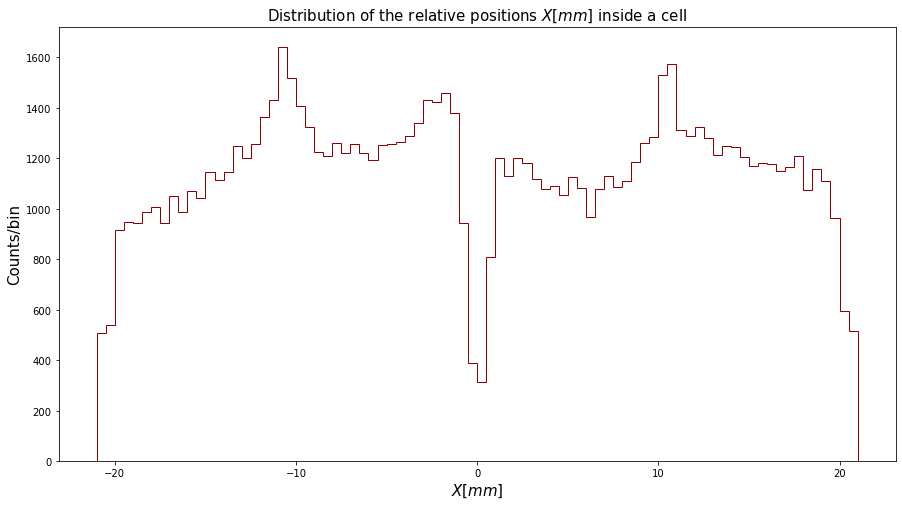

In [15]:
plt.clf()
fig, ax = plt.subplots(nrows=1, ncols=1, tight_layout=False, figsize=(15, 8))
sign = {'L':-1, 'R': 1}
histo = DF_off["X(mm)"].values*np.array([sign[sig] for sig in DF_off["LR"].values])
data, bins, __ = ax.hist(histo, bins=np.arange(-21,21.5,0.5), range=(-21, 21), histtype='step', color="darkred")
ax.set_xlabel(r"$X[mm]$", size=15)
ax.set_ylabel(r"Counts/bin", size=15)
ax.set_title(r"Distribution of the relative positions $X[mm]$ inside a cell", size=15)
plt.show()

As expected, the histogram of the relative positions recalls a uniform distribution for a cell: less counts are to be found in $0$ - representing an events that *directly* hits the wire - while higher counts can be seen located at both halfs of the semi-cells.

***

## 4. Visualizing the events

Create an array that will be used to visualize the detector chamber:

In [16]:
d = np.array([[4*i+j for i in range(16)] for j in range(1,5)])

Here we create a restricted dataframe with only the events we want to visualize. In this specific case we wanted to visualize 4 events of 4 hits and so we used a function that kept only events with such characteristic. <br>

In [54]:
disp_data = DF_off
d1 = DF_off[(DF_off['Chamber'] == 1)]
d2 = DF_off[(DF_off['Chamber'] == 2)]
d3 = DF_off[(DF_off['Chamber'] == 3)]
d4 = DF_off[(DF_off['Chamber'] == 4)]

event_list1 = [1112,14,34,9,22]
event_list2 = [34814,34734,34788,34716,34709]
event_list3 = [69199,69207,69237,69217,69184]
event_list4 = [148328,148322,148761,148319,148356]

def filter_by_ev(df, column, min_ev):
    freq = df[column].value_counts()
    frequent_values = freq[freq >= min_ev].index
    
    return df[df[column].isin(frequent_values)]


def find_event(event_list1, event_list2, event_list3, event_list4):
    d1n = pd.DataFrame(index = [], columns = disp_data.columns)
    for item in event_list1: 
        d1n = d1n.append(d1[d1['Event'] == item])

    d2n = pd.DataFrame(index = [], columns = disp_data.columns)
    for item in event_list2: 
        d2n = d2n.append(d2[d2['Event'] == item])

    d3n = pd.DataFrame(index = [], columns = disp_data.columns)
    for item in event_list3: 
        d3n = d3n.append(d3[d3['Event'] == item])

    d4n = pd.DataFrame(index = [], columns = disp_data.columns)
    for item in event_list4: 
        d4n = d4n.append(d4[d4['Event'] == item])
    
    return (d1n, d2n, d3n, d4n)

In [55]:
d1n, d2n, d3n, d4n = find_event(event_list1, event_list2, event_list3, event_list4)
det = [d1n, d2n, d3n, d4n]

This is code to draw the chamber and to add events in it. The wires are marked in black at the center of the cell, the events are the red dots. The cells in which the hit took place are colored in blue. The chamber is not at scale, the height should be much lower. <br>

The function is divided in two parts: one that draws the grid and enlightens the cells interested by an event and another that actually draws the red dot, with a specific position and with the L/R ambiguity resolved. This is because it was written in two parts, first to check if the preliminary results we obtained, pertaining only the description of the events with the cells, and later on to check if the final results, with complete description of the event were correct. 

In [56]:
def draw_chamber(array_indexes, array_cells, de):
    
    # first declare some variables and the figure in which the rectangles that constitute the grid will be put
    cmap = colors.ListedColormap(['white'])
    fig = plt.figure(figsize=(24,5), edgecolor = 'r')
    ax = fig.add_subplot()
    ax.axis('off')
    ax.add_artist(Line2D((0, 16), (0, 0), color='black', linewidth=2))
    ax.pcolor(d,edgecolors='white', linewidths=1, cmap=cmap)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title('\n Detector {}\n'.format(de.at[0, 'Chamber']), fontdict = {'fontsize':20})
    size, x_start, x_end, y_start, y_end = 16, 0., 16, 0., 4.
    jump_x = (x_end - x_start) / (2.0 * size)
    jump_y = (y_end - y_start) / (16)
    x_positions = np.linspace(start=x_start, stop=x_end, dtype = int, num=size, endpoint=False)
    y_positions = np.zeros((16))
    l1, l2, l3, l4 = d[3], d[1], d[2], d[0]
    x_pos = np.linspace(start=0, stop=len(array_cells), dtype = int, num=size, endpoint=False)
    y_pos = np.zeros((len(array_cells)))
    
    # now draw the grid, in particular colour differently cells that have registered hits
    for j in range(4):
        if j % 4 == 0:
            for i in range(16):
                if (4*i+4) in display_example:
                    rect = patches.Rectangle((0+i,0),1,1,linewidth=1,edgecolor='black',facecolor='lightskyblue')
                    ax.add_patch(rect)
                else: 
                    rect = patches.Rectangle((0+i,0),1,1,linewidth=1,edgecolor='black',facecolor='none')
                    ax.add_patch(rect)
                label = int(l1[i])
                text_x = x_positions[i] + 0.15 
                text_y = y_positions[i] + jump_y + 0.6
                circle_x = x_positions[i] + jump_x  
                circle_y = y_positions[i] + 0.5
                circle = patches.Circle((circle_x,circle_y),radius = 0.03,linewidth=1,edgecolor='black',facecolor='black')
                ax.add_patch(circle)
                ax.text(text_x, text_y, label, color='black', ha='center', va='center')
        if j % 4 == 1:
            for i in range(16):
                if (4*i+2) in display_example:
                    rect = patches.Rectangle((0.5+i,1),1,1,linewidth=1,edgecolor='black',facecolor='lightskyblue')
                    ax.add_patch(rect)
                else: 
                    rect = patches.Rectangle((0.5+i,1),1,1,linewidth=1,edgecolor='black',facecolor='none')
                    ax.add_patch(rect)          
                label = int(l2[i])
                text_x = x_positions[i] + 0.65 
                text_y = y_positions[i] + jump_y + 1.60
                circle_x = x_positions[i] + jump_x + 0.5 
                circle_y = y_positions[i] + 1.5
                circle = patches.Circle((circle_x,circle_y),radius = 0.03,linewidth=1,edgecolor='black',facecolor='black')
                ax.add_patch(circle)
                ax.text(text_x, text_y, label, color='black', ha='center', va='center')
        if j % 4 == 2:
            for i in range(16):
                if (4*i+3) in display_example:
                    rect = patches.Rectangle((0+i,2),1,1,linewidth=1,edgecolor='black',facecolor='lightskyblue')
                    ax.add_patch(rect)  
                else: 
                    rect = patches.Rectangle((0+i,2),1,1,linewidth=1,edgecolor='black',facecolor='none')
                    ax.add_patch(rect)
                label = int(l3[i])
                text_x = x_positions[i] + 0.15 
                text_y = y_positions[i] + jump_y + 2.60
                circle_x = x_positions[i] + jump_x 
                circle_y = y_positions[i] + 2.5
                circle = patches.Circle((circle_x,circle_y),radius = 0.03,linewidth=1,edgecolor='black',facecolor='black')
                ax.add_patch(circle)
                ax.text(text_x, text_y, label, color='black', ha='center', va='center')
        if j % 4 == 3:
            for i in range(16):
                if (4*i+1) in display_example:
                    rect = patches.Rectangle((0.5+i,3),1,1,linewidth=1,edgecolor='black',facecolor='lightskyblue')
                    ax.add_patch(rect)
                else: 
                    rect = patches.Rectangle((0.5+i,3),1,1,linewidth=1,edgecolor='black',facecolor='none')
                    ax.add_patch(rect)
                label = int(l4[i])
                text_x = x_positions[i] + 0.65
                text_y = y_positions[i] + jump_y + 3.60
                circle_x = x_positions[i] + jump_x +0.5
                circle_y = y_positions[i] + 3.5
                circle = patches.Circle((circle_x,circle_y),radius = 0.03,linewidth=1,edgecolor='black',facecolor='black')
                ax.add_patch(circle)
                ax.text(text_x, text_y, label, color='black', ha='center', va='center')
    
    # draw the actual events (L/R ambiguity resolved and positions at scale with the original one in the cell)
    for i in range(len(display_example)): 
        j = de.at[i, "Cell"]
        if j % 4 == 0: 
            for l, x in zip(l1, x_positions):
                if j == l:
                    if de["LR"][i] == 'R':
                        x_hit = x + 0.5 + (de["X(mm)"][i]*0.5)/L2
                    elif de["LR"][i] == 'L':
                        x_hit = x + 0.5 - (de["X(mm)"][i]*0.5)/L2
                    y_hit = y_positions[i] + 0.5
                    circle = patches.Circle((x_hit,y_hit),radius = 0.04,linewidth=1,edgecolor='r',facecolor='r')
                    ax.add_patch(circle)
        if j % 4 == 2: 
            for l, x in zip(l2, x_positions):
                if j == l:
                    if de["LR"][i] == 'R':
                        x_hit = x + 1 + (de["X(mm)"][i]*0.5)/L2
                    elif de["LR"][i] == 'L':
                        x_hit = x + 1 - (de["X(mm)"][i]*0.5)/L2
                    y_hit = y_positions[i] + 1.5
                    circle = patches.Circle((x_hit,y_hit),radius = 0.04,linewidth=1,edgecolor='r',facecolor='r')
                    ax.add_patch(circle)
        if j % 4 == 3: 
            for l, x in zip(l3, x_positions):
                if j == l:
                    if de["LR"][i] == 'R':
                        x_hit = x + 0.5 + (de["X(mm)"][i]*0.5)/L2
                    elif de["LR"][i] == 'L':
                        x_hit = x + 0.5 - (de["X(mm)"][i]*0.5)/L2
                    y_hit = y_positions[i] + 2.5
                    circle = patches.Circle((x_hit,y_hit),radius = 0.04,linewidth=1,edgecolor='r',facecolor='r')
                    ax.add_patch(circle)
        if j % 4 == 1: 
            for l, x in zip(l4, x_positions):
                if j == l:
                    if de["LR"][i] == 'R':
                        x_hit = x + 1 + (de["X(mm)"][i]*0.5)/L2
                    elif de["LR"][i] == 'L':
                        x_hit = x + 1 - (de["X(mm)"][i]*0.5)/L2
                    y_hit = y_positions[i] + 3.5
                    circle = patches.RegularPolygon((x_hit,y_hit), numVertices = 6, radius = 0.04,linewidth=1,edgecolor='r',facecolor='r')
                    ax.add_patch(circle)
            
            
    return plt.show()

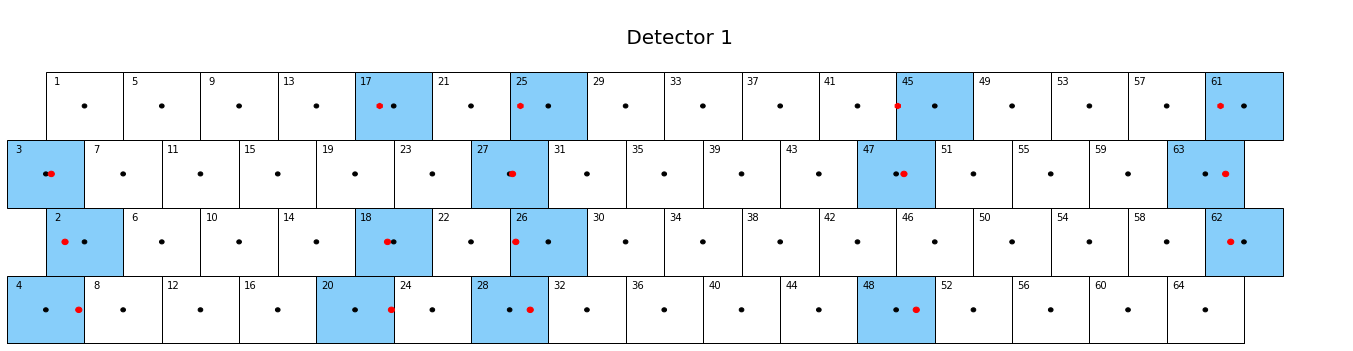

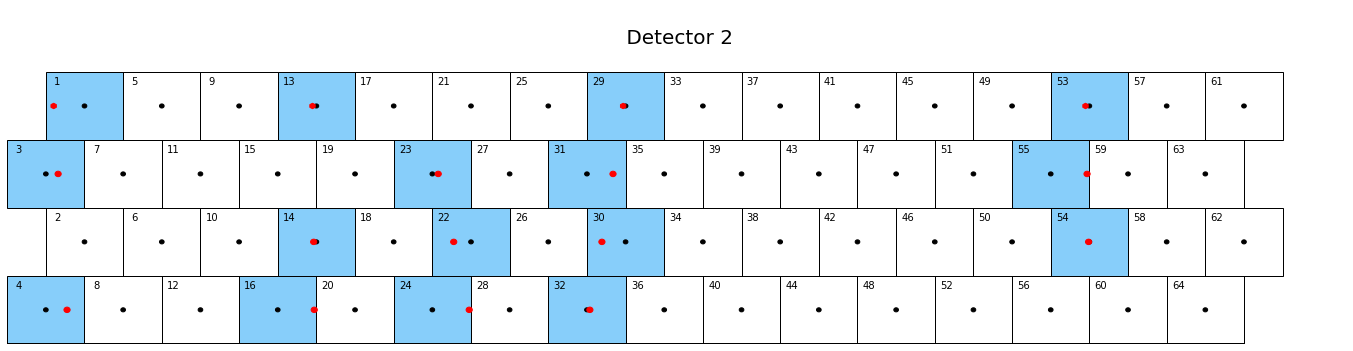

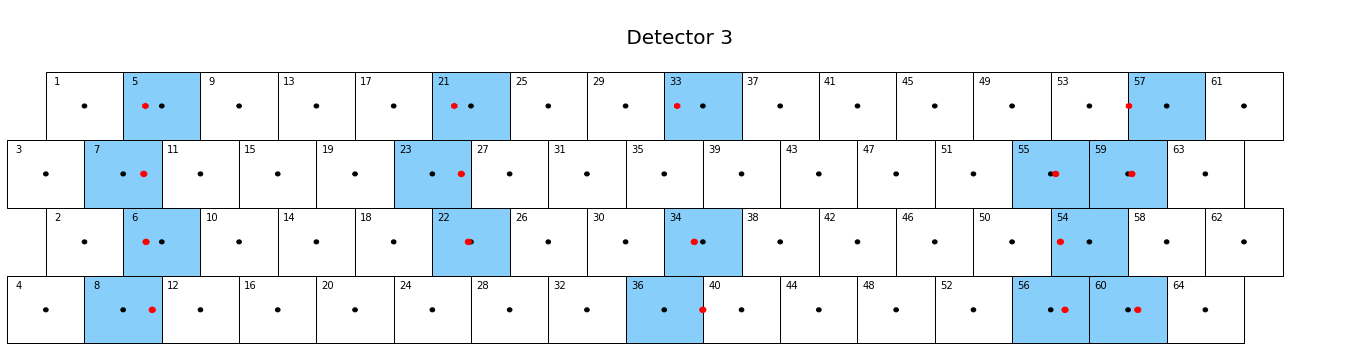

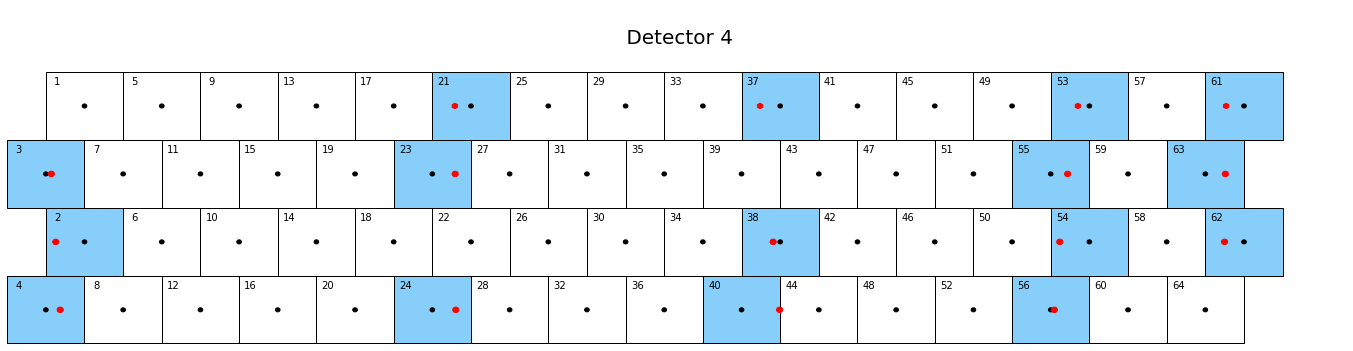

In [57]:
for de in det:                          # iterate on the dataframes corresponding to each detector
    de = de.set_index(np.arange(16))    # resetting the indexes from 0 to 15                        
    display_example = np.array(de['Cell'])                   
    draw_chamber(d, display_example, de)

## 5. Conclusion

Our work provides an algorithm capable of identifying events in drift tube detectors: the graphical check validates the results obtained, since the points are resonably distributed in time and align through the layers, even without the usage of trigger information.

On the other hand, there is room for improvement for what concerns the computational cost of the program: while a summary of our efforts on the topic is written below, further improvements could be achieved via the implementation of auxiliar code exploiting trigger information and the reduction of patterns under investigation.

***

## 6. Appendix: code optimization

Particular attention was put into developing a sustainable code to deal with the large amount of data that was provided. In order to do so, we tried to exploit at our best the properties of the Pandas library and to avoid using useless loops, which are expecially computationally demanding. Moreover, we tried to use the power of Numba library to accelerate our script, but we faced some compatibility issues between Numba and Pandas. We gave a try to convert Pandas structures into Numpy ones so to be able to use Numba, but in the end this whole process would have required to rethink completely the approach to data analisys.<br>
Therefore, our work was centered on trying to redesign the code reducing the use of statements which could make it slower: the first program we wrote is reported below, while the one we set up is the one used in the previous part of this work. The performance is slightly better on a small dataset ($\sim15\%$), but becomes more and more relevant with the increasing size of the dataset.<br>
In the end, due to short time and permissions problems, we were not able to use the provided CloudVeneto GPUs: this as well would have given our code a significant boost. 

In [ ]:
start_time = time.time()

pd.options.mode.chained_assignment = None  # default='warn'

def Find_Next_1(i,data,ev_counter):                                 # Finds the next hit after first layer
    df = data.copy(deep = False)
    t_start = df.at[i,"Absolute"]
    cell0 = df.at[i,"Cell"]
    cell1, cell2, cell3 = cell0-2, cell0-6, cell0-1                 # Define cells to look at (cell1, cell2 belonging 
                                                                    # to layer 2, cell3 to layer3)
    df2 = df[(df["Cell"] == cell1) | (df["Cell"] == cell2)]         # Create subdataframe to analyse
    df2["Absolute"] = np.abs(df2["Absolute"] - t_start)    
    if (df2.empty == False) and (df2["Absolute"].min() < 400.):                         
        i_next = df2["Absolute"].idxmin()                           # Take the index of the closest click in time
        data.at[i,"Event"] = ev_counter                             # Set the number of the event on the original dataset
        data.at[i_next, "Event"] = ev_counter                       # both in the row of the first and second layer cell
        return i_next                                               # Return index to start again and corresponding cell
    else: 
        df3 = df[(df["Cell"] == cell3)]                             # Create subdataframe to analyse
        df3["Absolute"] = np.abs(df3["Absolute"] - t_start)
    if (df3.empty == False) and (df3["Absolute"].min() < 400.):
        i_next = df3["Absolute"].idxmin()                           # Take the index of the closest click in time
        data.at[i,"Event"] = ev_counter                             # Set the number of the event on the original dataset
        data.at[i_next, "Event"] = ev_counter                       # both in the row of the first and second layer cell
        return i_next
    else: 
        return -1

def Find_Next_2(i,cstart,data,ev_counter):                          # Finds the next hit after second layer
    df = data.copy(deep = False)
    t_start = df.at[i,"Absolute"]
    cell0 = df.at[i,"Cell"]
    if cstart - cell0 == 6:                                         # Define cells to look at (cell1, cell2
        cell1, cell2 = cell0 + 5, cell0 - 1                         # belonging to layer 3, cell3 to layer4)
    else:
        cell1, cell2 = cell0 + 1, cell0 - 1                          
    df2 = df[(df["Cell"] == cell1)]
    df2["Absolute"] = np.abs(df2["Absolute"] - t_start)    
    if (df2.empty == False) and (df2["Absolute"].min() < 400.):                         
        i_next = df2["Absolute"].idxmin()                           # Take the index of the closest click in time
        data.at[i,"Event"] = ev_counter                             # Set the number of the event on the original dataset
        data.at[i_next, "Event"] = ev_counter                       # both in the row of the first and second layer cell
        return i_next                                               # Return index to start again and corresponding cell
    else: 
        df3 = df[(df["Cell"] == cell2)]                             # Create subdataframe to analyse
        df3["Absolute"] = np.abs(df3["Absolute"] - t_start)
        if (df3.empty == False) and (df3["Absolute"].min() < 400.):
            i_next = df3["Absolute"].idxmin()                       # Take the index of the closest click in time
            data.at[i,"Event"] = ev_counter                         # Set the number of the event on the original dataset
            data.at[i_next, "Event"] = ev_counter                   # both in the row of the first and second layer cell
            return i_next
        else: 
            return -1

def Find_Next_3(i,cstart,data,ev_counter):                          # Finds the next hit after third layer
        df = data.copy(deep = False)
        t_start = df.at[i,"Absolute"]
        cell0 = df.at[i,"Cell"]
        if cstart - cell0 == -5: 
            cell1 = cell0 -6
            df = df[(df["Cell"] == cell1)]
        if cstart - cell0 == -1: 
            cell1 = cell0 -2
            df = df[(df["Cell"] == cell1)]
        else:
            cell1, cell2 = cell0 -5, cell0 - 2                      # Define cells to look at (cell1, cell2 belonging to layer 4)
        df = df[(df["Cell"] == cell1) | (df["Cell"] == cell2)]  
        df["Absolute"] = np.abs(df["Absolute"] - t_start)  
        if df.empty == False and (df["Absolute"].min() < 400.):            
            i_next = df["Absolute"].idxmin()                        # Take the index of the closest click in time
            data.at[i_next,"Event"] = ev_counter                    # Set the number of the event on the original dataset
            return i_next                                           # Return index to start again and corresponding cell
        else: 
            return -1    


def Find_Next_from_2(i, data, ev_counter):
    df = data.copy(deep=False)
    t_start = df.at[i,"Absolute"]
    cell0 = df.at[i, "Cell"]
    cell1, cell2 = cell0 + 1, cell0 + 5
    df = df[(df["Cell"] == cell1) | (df["Cell"] == cell2)]
    df["Absolute"] -= t_start
    df = df[df["Absolute"] > 0]                                # Find the only times that occur later than the hit on first layer         
    if df.empty == False and (df["Absolute"].min() < 400.):       
        i_next = df["Absolute"].idxmin()                       # Take the index of the closest click in time
        data.at[i,"Event"] = ev_counter                        # Set the number of the event on the original dataset
        data.at[i_next, "Event"] = ev_counter                  # both in the first layer cell row and in the second layer cell row
        return i_next                                          # Return index to start again
    else:
        return -1


def Is_Event(df, ev_counter):                                         
    layer1 = [4*i+4 for i in range(16)]                               # Divides cell numbers in layers
    layer2 = [4*i+2 for i in range(16)]
    layer3 = [4*i+3 for i in range(16)]
    layer4 = [4*i+1 for i in range(16)]

    idx_lay1 = pd.Series(np.array(df.index[df["Layer"] == 1]))
    idx_lay2 = pd.Series(np.array(df.index[df["Layer"] == 2]))
  
    if idx_lay1.empty == False:
        for i in idx_lay1:                                             # For each time a particle hits first the first layer:
        ev_counter += 1 
        i_cell = df.at[i,"Cell"]                            
        j = Find_Next_1(i, df, ev_counter)                             # See if (and when) it hits the second layer
        if j != -1:
            j_cell = df.at[j,"Cell"]
            if j_cell in layer2:                                       # If so, look for the hit in the third...
                k = Find_Next_2(j, i_cell, df, ev_counter)
                if k != -1:
                k_cell = df.at[k,"Cell"]
                if k_cell in layer3:
                    t = Find_Next_3(k, j_cell, df, ev_counter)
            if j_cell in layer3:                                       # ...otherwise for the hit in the fourth
                t = Find_Next_3(j, i_cell, df, ev_counter)
   
    if idx_lay2.empty == False: 
        for i in idx_lay2:
            if df.at[i,"Event"] == 0:
            ev_counter += 1
            k = Find_Next_from_2(i, df, ev_counter)
            if k != -1:
                k_cell = df.at[k,"Cell"]
                if any(df["Cell"] == k_cell - 1):
                    df.at[(np.abs(df["Absolute"]-df.at[k,"Absolute"])).idxmin(), "Event"] = ev_counter  

    return ev_counter